# Imports

In [1]:
%load_ext autoreload
%autoreload 2
%aimport mc.util 
from util import *
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy
import os
import pyximport; pyximport.install()

plt.style.use('ggplot')
matplotlib.rcParams["mathtext.fontset"] = "cm"

os.environ['CC'] = 'clang'
os.environ['CXX'] = 'clang -shared'

In [26]:
from scipy.interpolate import splrep, splev, BSpline

def rescale(t, y, L, tc, nu, k_over_nu, a, omega, b, phi):
    xs = (t-tc)/tc * L**(1/nu) + b * L**(-phi)
    ys = y * L**(-k_over_nu) * (1 + a * L**(-omega))**(-1.)
    return xs, ys

def collapse(curves, ax, bounds, yvar_name, exponent_name):
    colors = gen_colors(curves)

    p = None
    boundmin = None
    boundmax = None
    def fun(x, curves, deg):
        nonlocal p, boundmin, boundmax
        tc, nu, k_over_nu, a, omega, b, phi = x
        boundmin = -np.inf
        boundmax = np.inf
        xmin = np.inf
        xmax = -np.inf
        all_xs, all_ys = [], []
        for L, t, y in curves:
            st, sy = rescale(t, y, L, tc, nu, k_over_nu, a, omega, b, phi)
            all_xs = np.concatenate((all_xs, st))
            all_ys = np.concatenate((all_ys, sy))
            boundmin = max(boundmin, np.amin(st))
            boundmax = min(boundmax, np.amax(st))
            xmin = min(xmin, np.amin(st))
            xmax = max(xmax, np.amax(st))

        indices = (all_xs>=boundmin)*(all_xs<=boundmax)
        all_xs, all_ys = all_xs[indices], all_ys[indices]

        p = np.polyfit(all_xs, all_ys, deg)
        chisq = np.sum((np.polyval(p, all_xs) - all_ys)**2/np.std(all_ys)**2) * ((xmax - xmin)/(boundmax-boundmin))
        return chisq

    for L, t, y in curves:
        ax[0].plot(t, y, color=colors[L], label=L)

    p0 = []
    pbounds = []
    for prop in ["tc", "nu", "k_over_nu", "a", "omega", "b", "phi"]:
        if isinstance(bounds[prop], tuple):
            pbounds.append(bounds[prop])
            p0.append((bounds[prop][0] + bounds[prop][1])/2)
        else:
            pbounds.append((bounds[prop], bounds[prop]))
            p0.append(bounds[prop])

    res = scipy.optimize.minimize(fun, p0, bounds=pbounds, args=(curves, 8))
    tc, nu, k_over_nu, a, omega, b, phi = res.x

    allx, ally = np.array([]), np.array([])
    for L, t, y in curves:
        st, sy = rescale(t, y, L, tc, nu, k_over_nu, a, omega, b, phi)
        allx = np.concatenate((allx, st))
        ally = np.concatenate((ally, sy))
        ax[1].plot(st, sy, color=colors[L], label=L)

    xs = np.linspace(boundmin, boundmax, 100)
    yrange = np.amax(ally) - np.amin(ally)
    ax[1].set_ylim([np.amin(ally)-yrange*0.05, np.amax(ally)+yrange*0.05])
    ax[1].plot(xs, np.polyval(p, xs))

    ax[0].set_ylabel(f"${yvar_name}$")
    ax[0].set_xlabel("$T$")
    if exponent_name is None:
        ax[1].set_title(f"$T_c={tc:.3f}, \\nu={nu:.2f}$")
        ax[1].set_ylabel(f"${yvar_name}$")
    else:
        ax[1].set_title(f"$T_c={tc:.3f}, \\nu={nu:.2f}, {exponent_name}={k_over_nu*nu:.2f}$")
        ax[1].set_ylabel(f"${yvar_name} L^{{-{exponent_name}/\\nu}}$")
    ax[1].set_xlabel("$(T-T_c)L^{-\\nu}/T_c$")
    print(res.x)


def plot_all_collapse(energy_curves, corr_curves, order_curves, sus_curves, energy_binder_curves, binder_curves, tc_range, nu_range, alpha_range=(0.5, 1.5)):
    plt.close("all")
    fig, ax = plt.subplots(2, 5, figsize=[14,7])

    collapse(energy_curves, ax[:, 0], {
        "tc": tc_range,
        "nu": nu_range,
        "k_over_nu": alpha_range,
        "a": (-1, 1),
        "omega": (-3, 3),
        "b": (-1, 1),
        "phi": (-3, 3),
    }, "(C_v/N)", "\\alpha")

    if corr_curves is not None:
        collapse(corr_curves, ax[:, 1], {
            "tc": tc_range,
            "nu": nu_range,
            "k_over_nu": 0,
            "a": (-1, 1),
            "omega": (-3, 3),
            "b": (-1, 1),
            "phi": (-3, 3),
        }, "(\\xi_a/L)", None)

    collapse(order_curves, ax[:, 2], {
        "tc": tc_range,
        "nu": nu_range,
        "k_over_nu": (-1, 2),
        "a": (-1, 1),
        "omega": (-3, 3),
        "b": (-1, 1),
        "phi": (-3, 3),
    }, "S(q=K)", "\\beta")

    collapse(sus_curves, ax[:, 3], {
        "tc": tc_range,
        "nu": nu_range,
        "k_over_nu": (-2, 2),
        "a": (-1, 1),
        "omega": (-3, 3),
        "b": (-1, 1),
        "phi": (-3, 3),
    }, "\chi", "\\gamma")

    ax[0, 0].set_title("Critical heat and collapse")
    ax[0, 1].set_title("Correlation length and collapse")
    ax[0, 2].set_title("Order parameter and collapse")
    ax[0, 3].set_title("Susceptibility and collapse")

    colors = gen_colors(energy_binder_curves)
    for L, t, y in energy_binder_curves:
        ax[0, 4].plot(t, y, color=colors[L])
    ax[0, 4].set_title("Energy cumulant")
    ax[0, 4].set_xlabel("$T$")
    ax[0, 4].set_ylabel("$1-\\langle E^4 \\rangle/3\\langle E^2\\rangle^2$")

    colors = gen_colors(binder_curves)
    for L, t, y in binder_curves:
        ax[1, 4].plot(t, y, color=colors[L])
    ax[1, 4].set_title("Order parameter cumulant")
    ax[1, 4].set_ylabel("$1-\\langle S(q=K)^4 \\rangle/2\\langle S(q=K)^2\\rangle^2$")
    ax[1, 4].set_xlabel("$T$")

    fig.tight_layout()

In [16]:
import collections
import json
Props = collections.namedtuple("Props", "e cv b_e k chi_k b_k s chi_s b_s")

def get_all_moments(glob, pkl):
    import pickle
    if os.path.exists(pkl):
        with open(pkl, "rb") as f:
            return pickle.load(f)
    data = []
    for f in enum_files(glob):
        e, k, sl = read_histogram(f["fname"], skip=10000)
        em, cem = calculate_moments(e)
        km, ckm = calculate_moments(k)
        sm, csm = calculate_moments(np.abs(sl))
        data.append((f, em, cem, km, ckm, sm, csm))
    with open(pkl, "wb") as f:
        pickle.dump(data, f)
    return data

def curves_from_moments(data):
    lens = sorted(set(x[0]["l"] for x in data))
    curves = []
    for l in lens:
        ts, e, cv, e4, k, kchi, k4, s, schi, s4 = tuple([] for i in range(10))
        for d in sorted((d for d in data if d[0]["l"] == l), key=lambda x: x[0]["t"]):
            prop, em, cem, km, ckm, sm, csm = d
            n = prop["l"]**2/3 - prop["r"]/3
            t = prop["t"]
            ts.append(t)
            e.append(em[1]/n)
            cv.append(cem[2]/t**2/n)
            e4.append(1-em[4]/3/em[2]**2)
            k.append(km[1]/n)
            kchi.append(ckm[2]/t/n)
            k4.append(1-km[4]/2/km[2]**2)
            s.append(sm[1]/n)
            schi.append(csm[2]/t/n**2)
            s4.append(1-sm[4]/3/sm[2]**2)
        curves.append((l, np.array(ts), Props(*tuple(np.array(x) for x in [e, cv, e4, k, kchi, k4, s, schi, s4]))))
    return curves

def curves_from_jsons(fmt, lens):
    curves = []
    for l in lens:
        with open(fmt.format(l), "r") as f:
            data = json.load(f)
            curves.append((l, np.array(data["t"]), Props(*tuple(np.array(data[x]) if x in data else None for x in ["e", "cv", "b_e", "k", "chi_k", "b_k", "s", "chi_s", "b_s"]))))
    return curves

def pick_curve(curves, name, bounds=None):
    if bounds is None:
        return [(l, t, p._asdict()[name]) for l, t, p in curves]
    else:
        lb, ub = bounds
        return [(l, t[(lb<t)*(t<ub)], p._asdict()[name][(lb<t)*(t<ub)]) for l, t, p in curves]

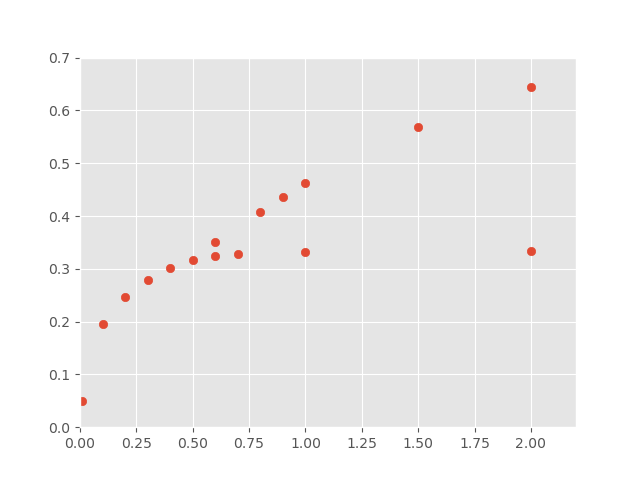

In [ ]:
points = []
points.append((0.01, 0.05))
points.append((0.1, 0.196))
points.append((0.2, 0.247))
points.append((0.3, 0.279))
points.append((0.4, 0.302))
points.append((0.5, 0.317))
points.append((0.6, 0.324))
points.append((0.7, 0.328))
points.append((1, 0.332))
points.append((2, 0.334))

points.append((0.6, 0.350))
points.append((0.8, 0.4082))
points.append((0.9, 0.4362))
points.append((1, 0.463))
points.append((1.5, 0.568))
points.append((2, 0.644))

plt.figure()
plt.xlim([0, 2.2])
plt.ylim([0, 0.7])
plt.scatter(np.array(points).T[0], np.array(points).T[1])

## Weak transitions

### J=0.1

[ 1.95991186e-01  5.50440723e-01  8.07051576e-01 -8.67463901e-09
  0.00000000e+00]
[1.95989818e-01 5.50509963e-01 0.00000000e+00 6.59948508e-11
 0.00000000e+00]
[ 1.95663172e-01  5.66024438e-01  1.92954453e-02  4.89185679e-07
 -9.02774828e-14]
[ 1.95825080e-01  6.00000000e-01  2.00000000e+00 -3.10722344e-07
 -6.54520579e-11]


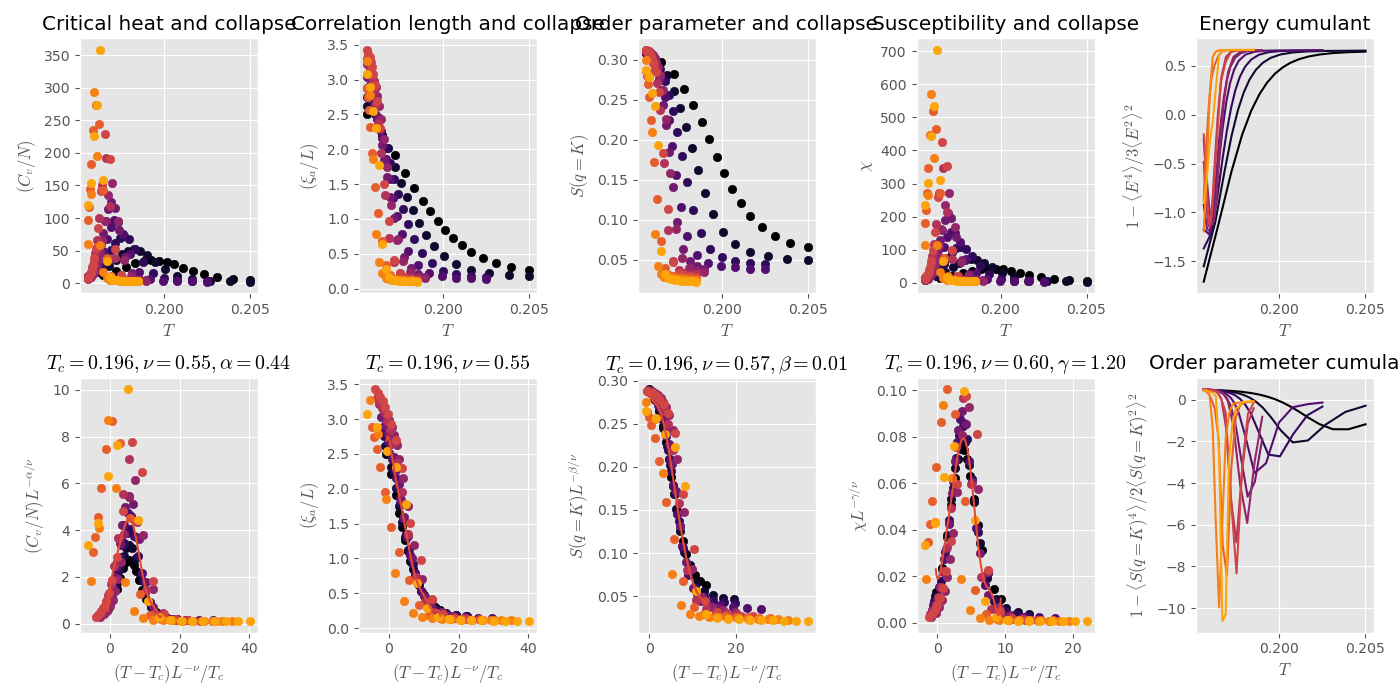

No such comm: 56b7bc9aa092450eb0a6da195b037d6b
No such comm: 56b7bc9aa092450eb0a6da195b037d6b
No such comm: 56b7bc9aa092450eb0a6da195b037d6b
No such comm: 56b7bc9aa092450eb0a6da195b037d6b
No such comm: 56b7bc9aa092450eb0a6da195b037d6b
No such comm: 56b7bc9aa092450eb0a6da195b037d6b
No such comm: 56b7bc9aa092450eb0a6da195b037d6b
No such comm: 56b7bc9aa092450eb0a6da195b037d6b
No such comm: 56b7bc9aa092450eb0a6da195b037d6b
No such comm: 56b7bc9aa092450eb0a6da195b037d6b
No such comm: 56b7bc9aa092450eb0a6da195b037d6b
No such comm: 56b7bc9aa092450eb0a6da195b037d6b
No such comm: 56b7bc9aa092450eb0a6da195b037d6b
No such comm: 56b7bc9aa092450eb0a6da195b037d6b
No such comm: 56b7bc9aa092450eb0a6da195b037d6b


In [19]:
plot_all_collapse(
    [c for c in get_all_curves(["new-data/vsweeps/binder/0.1b/*/energy.dat"])],
    [c for c in get_all_curves(["new-data/vsweeps/binder/0.1b/*/order.dat"], prop="corr")],
    [c for c in get_all_curves(["new-data/vsweeps/binder/0.1b/*/order.dat"], prop="k")],
    [c for c in get_all_curves(["new-data/vsweeps/binder/0.1b/*/order.dat"], prop="ksus")],
    [c for c in get_all_curves(["new-data/vsweeps/binder/0.1b/*/energy.dat"], prop="eb")],
    [c for c in get_all_curves(["new-data/vsweeps/binder/0.1b/*/order.dat"], prop="kb")],
    (0.195, 0.197),
    (0.5, 0.6)
)

### J=0.2

[ 2.46729949e-01  5.46453367e-01  1.53800195e+00  1.79888957e-02
 -4.05604602e-05]
[ 2.46774313e-01  5.43858660e-01  0.00000000e+00  1.97137904e-06
 -4.60907596e-12]
[ 2.46731127e-01  5.30104780e-01 -9.66438027e-02  2.24609044e-04
 -8.43261047e-11]
[ 0.246       0.6         1.69000499 -0.25260065 -0.09634289]


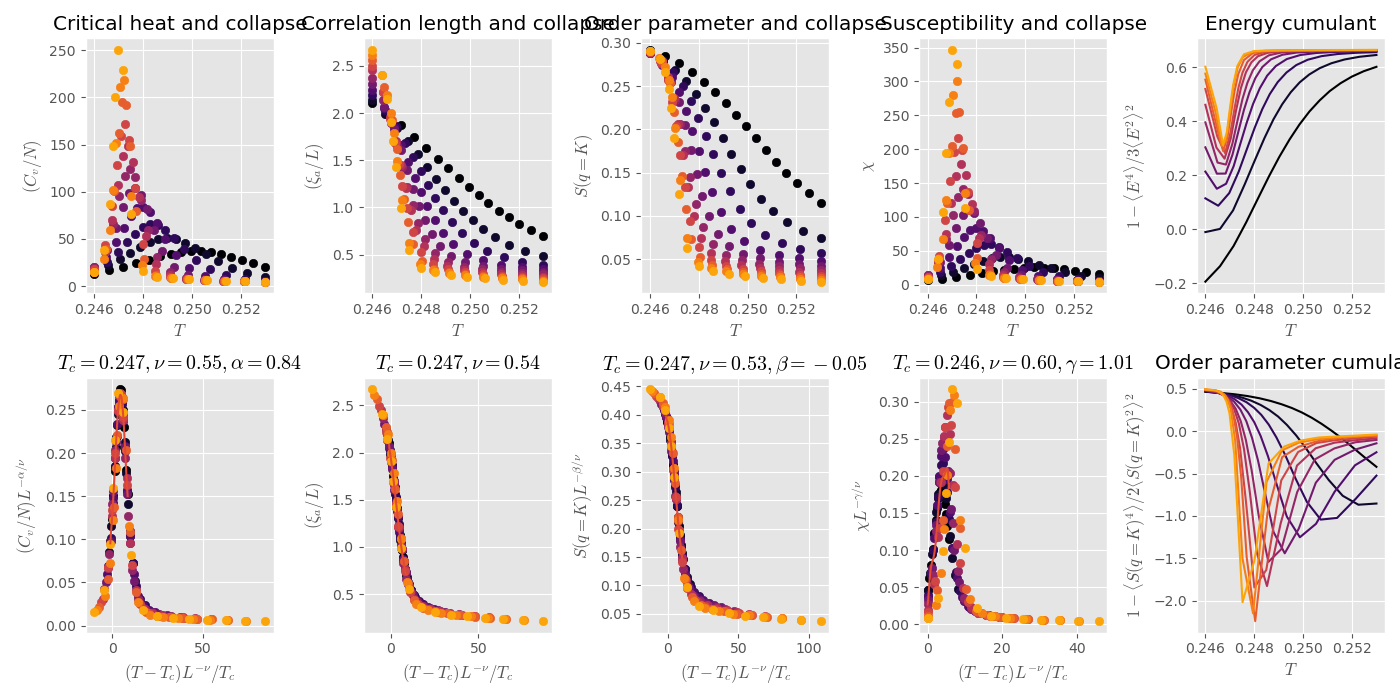

In [18]:
skip=50000
plot_all_collapse(
    [c for c in get_all_curves(["new-data/vsweeps/binder/0.2d/*/energy.dat"])],
    [c for c in get_all_curves(["new-data/vsweeps/binder/0.2d/*/order.dat"], prop="corr")],
    [c for c in get_all_curves(["new-data/vsweeps/binder/0.2d/*/order.dat"], prop="k")],
    [c for c in get_all_curves(["new-data/vsweeps/binder/0.2d/*/order.dat"], prop="ksus")],
    [c for c in get_all_curves(["new-data/vsweeps/binder/0.2f/*/energy.dat"], prop="eb")],
    [c for c in get_all_curves(["new-data/vsweeps/binder/0.2d/*/order.dat"], prop="kb")],
    (0.246, 0.247),
    (0.5, 0.6)
)

### J=0.3

[ 2.79235314e-01  5.62762790e-01  1.31107625e+00  1.36662364e-08
 -2.94048999e-09]
[2.79109673e-01 6.00000000e-01 0.00000000e+00 3.50990209e-10
 0.00000000e+00]
[ 2.79194857e-01  5.64862975e-01 -1.11740803e-01  1.47203805e-06
  8.35666080e-10]
[ 2.79194019e-01  5.61595189e-01  1.98443981e+00 -1.19539761e-06
  1.27297018e-09]


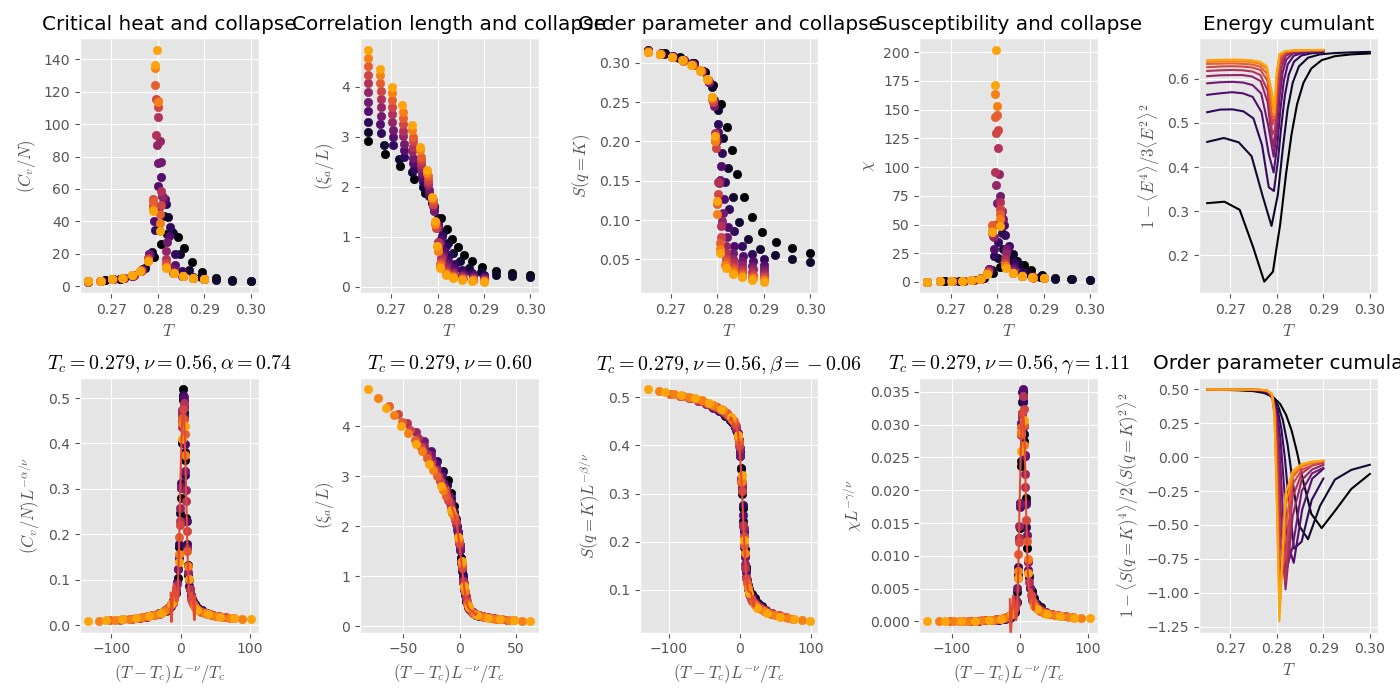

In [17]:
skip=50000
plot_all_collapse(
    [c for c in get_all_curves(["new-data/vsweeps/binder/0.3c/*/energy.dat"])],
    [c for c in get_all_curves(["new-data/vsweeps/binder/0.3c/*/order.dat"], prop="corr")],
    [c for c in get_all_curves(["new-data/vsweeps/binder/0.3c/*/order.dat"], prop="k")],
    [c for c in get_all_curves(["new-data/vsweeps/binder/0.3c/*/order.dat"], prop="ksus")],
    [c for c in get_all_curves(["new-data/vsweeps/binder/0.3c/*/energy.dat"], prop="eb")],
    [c for c in get_all_curves(["new-data/vsweeps/binder/0.3c/*/order.dat"], prop="kb")],
    (0.279, 0.28),
    (0.5, 0.6)
)

### J=0.4

[ 3.02328484e-01  6.81083291e-01  9.48619768e-01 -4.81740358e-08
 -2.44551192e-09]
[3.02070738e-01 8.00000000e-01 0.00000000e+00 5.72064635e-10
 0.00000000e+00]
[ 3.02356983e-01  6.49655045e-01 -1.40839325e-01 -7.67344757e-08
  1.23406870e-09]
[ 3.02312973e-01  6.61090893e-01  1.74694467e+00  4.35248169e-07
 -1.97766068e-09]


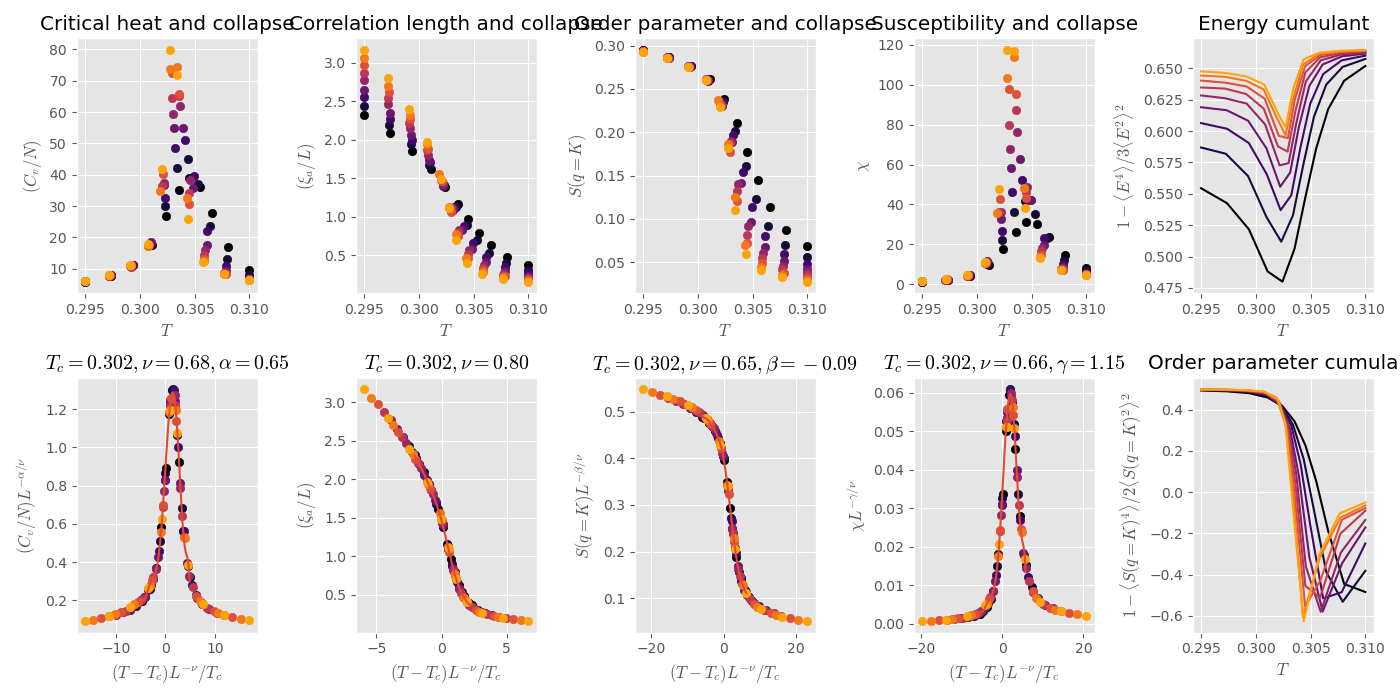

In [16]:
skip=50000
plot_all_collapse(
    [c for c in get_all_curves(["new-data/vsweeps/binder/0.4/*/energy.dat"])],
    [c for c in get_all_curves(["new-data/vsweeps/binder/0.4/*/order.dat"], prop="corr")],
    [c for c in get_all_curves(["new-data/vsweeps/binder/0.4/*/order.dat"], prop="k")],
    [c for c in get_all_curves(["new-data/vsweeps/binder/0.4/*/order.dat"], prop="ksus")],
    [c for c in get_all_curves(["new-data/vsweeps/binder/0.4/*/energy.dat"], prop="eb")],
    [c for c in get_all_curves(["new-data/vsweeps/binder/0.4/*/order.dat"], prop="kb")],
    (0.300, 0.305),
    (0.5, 0.8)
)

## Continuous transitions

[3.16800000e-01 9.08558470e-01 5.00000000e-01 6.39117027e-06
 1.60965373e-07 5.26594316e-06 4.04235320e-08]
[ 3.16800000e-01  1.01468907e+00  0.00000000e+00  2.91938787e-09
 -8.81719315e-14  4.08714792e-09 -1.19432411e-13]
[ 3.16800000e-01  9.56058936e-01 -9.85630325e-02 -4.83824814e-07
 -7.54234415e-10  1.36795806e-07 -6.66368741e-09]
[ 3.16800000e-01  1.02271972e+00  1.55043511e+00 -4.51902053e-06
  2.97897147e-08 -4.15026019e-05  1.32525116e-06]


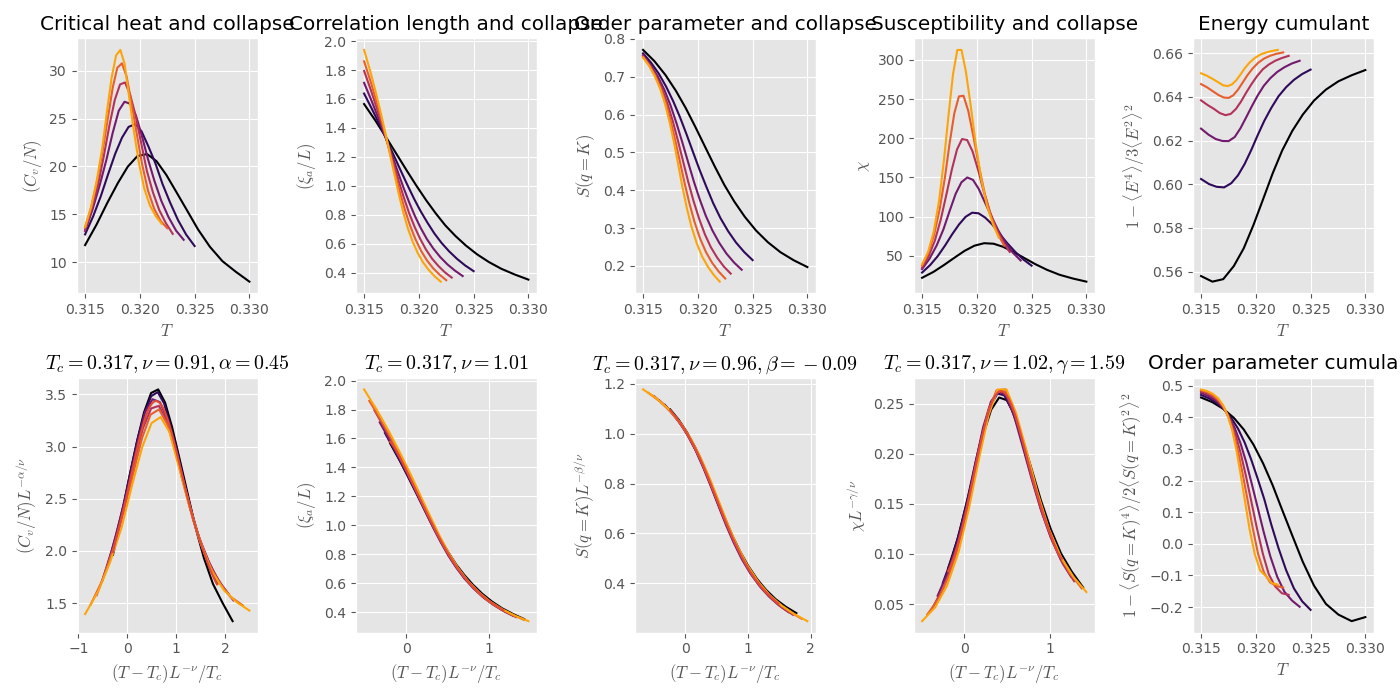

In [36]:
skip=50000
plot_all_collapse(
    [c for c in get_all_curves(["new-data/vsweeps/binder/0.5b/*/energy.dat"])],
    [c for c in get_all_curves(["new-data/vsweeps/binder/0.5b/*/order.dat"], prop="corr")],
    [c for c in get_all_curves(["new-data/vsweeps/binder/0.5b/*/order.dat"], prop="k")],
    [c for c in get_all_curves(["new-data/vsweeps/binder/0.5b/*/order.dat"], prop="ksus")],
    [c for c in get_all_curves(["new-data/vsweeps/binder/0.5b/*/energy.dat"], prop="eb")],
    [c for c in get_all_curves(["new-data/vsweeps/binder/0.5b/*/order.dat"], prop="kb")],
    (0.3167, 0.3168),
    (0.6, 1.2)
)

[ 3.24667701e-01  7.83123313e-01  5.00000000e-01 -9.29208354e-06
 -4.85459138e-05 -1.24982483e-06 -1.08111135e-08]
[ 3.24549840e-01  8.81493089e-01  0.00000000e+00 -2.12755574e-08
 -2.67267309e-13 -3.64678097e-08  7.33964428e-13]
[ 3.24777425e-01  8.43060495e-01 -1.53384807e-01 -8.72774477e-07
 -8.55930813e-09 -2.16044256e-07 -6.66115601e-09]
[ 3.24623669e-01  8.70699803e-01  1.68396327e+00  6.05772617e-04
  1.29756724e-07 -5.33530892e-04  5.08679770e-06]


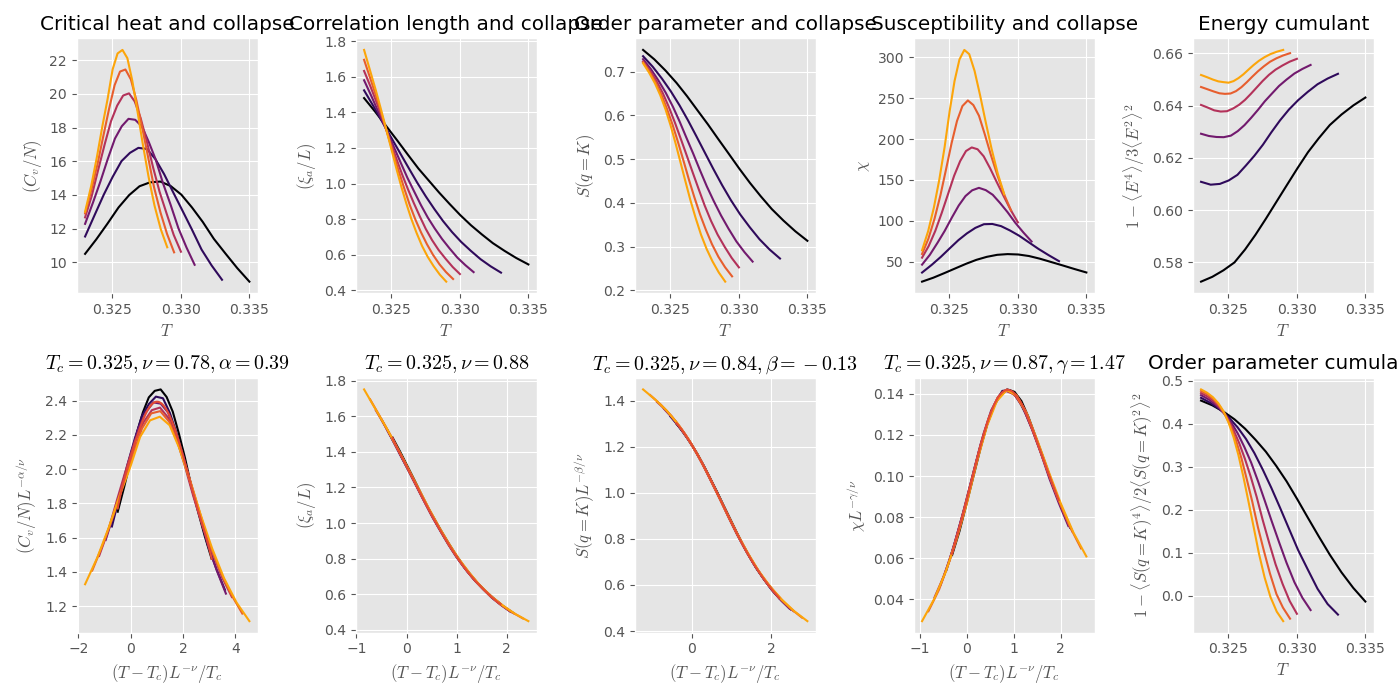

In [37]:
skip=100000
plot_all_collapse(
    [c for c in get_all_curves(["new-data/vsweeps/binder/0.6b/*/energy.dat"], skip=skip)],
    [c for c in get_all_curves(["new-data/vsweeps/binder/0.6b/*/order.dat"], prop="corr", skip=skip)],
    [c for c in get_all_curves(["new-data/vsweeps/binder/0.6b/*/order.dat"], prop="k", skip=skip)],
    [c for c in get_all_curves(["new-data/vsweeps/binder/0.6b/*/order.dat"], prop="ksus", skip=skip)],
    [c for c in get_all_curves(["new-data/vsweeps/binder/0.6b/*/energy.dat"], prop="eb", skip=skip)],
    [c for c in get_all_curves(["new-data/vsweeps/binder/0.6b/*/order.dat"], prop="kb", skip=skip)],
    (0.322, 0.327),
    (0.5, 0.9)
)

[ 3.52914846e-01  1.50000000e+00  1.04631034e-01 -1.06315080e-06
  9.90335922e-08 -4.27655313e-07 -2.07484391e-08]
[ 3.51910941e-01  9.31980382e-01 -1.70807543e-01 -1.39374128e-08
  2.69136818e-12  1.26717508e-06 -6.51162341e-08]
[ 3.49638554e-01  1.05718265e+00  1.73246159e+00  2.17160672e-08
 -2.14104131e-07  7.33678248e-08 -3.03661314e-07]


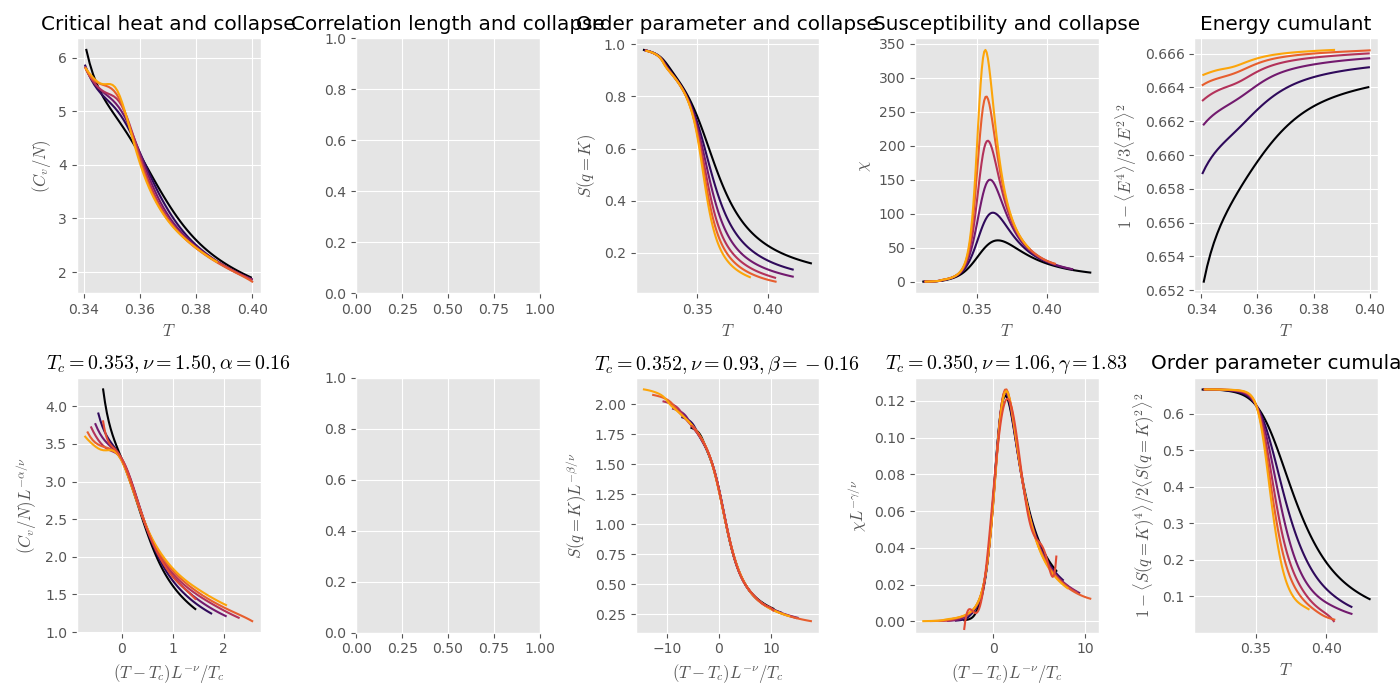

In [34]:
# curves = curves_from_moments(get_all_moments("new-data/vsweeps/binder-slp/0.6/*0.6*/histogram.dat", "new-data/binder-slp-0.6.pkl"))
curves = curves_from_jsons("new-data/mhr/{}_slp_0.6.json", range(36, 96+1, 12))

plot_all_collapse(
    pick_curve(curves, "cv", (0.34, 0.4)),
    None,
    pick_curve(curves, "s"),
    pick_curve(curves, "chi_s"),
    pick_curve(curves, "b_e", (0.34, 0.4)),
    pick_curve(curves, "b_s"),
    (0.349, 0.353),
    (0.5, 1.5),
    alpha_range=(0, 0.5),
)

[ 3.27853306e-01  9.00000000e-01  2.50942231e-03  1.08384369e-07
 -1.50429916e-11]
[ 3.28313706e-01  8.94991812e-01  0.00000000e+00 -5.11008463e-08
 -2.34603928e-12]
[ 3.28485153e-01  8.32312884e-01 -1.33573568e-01 -7.27604310e-08
 -3.45453829e-09]
[3.28434258e-01 8.47905892e-01 1.71519342e+00 7.00201927e-07
 2.68951584e-10]


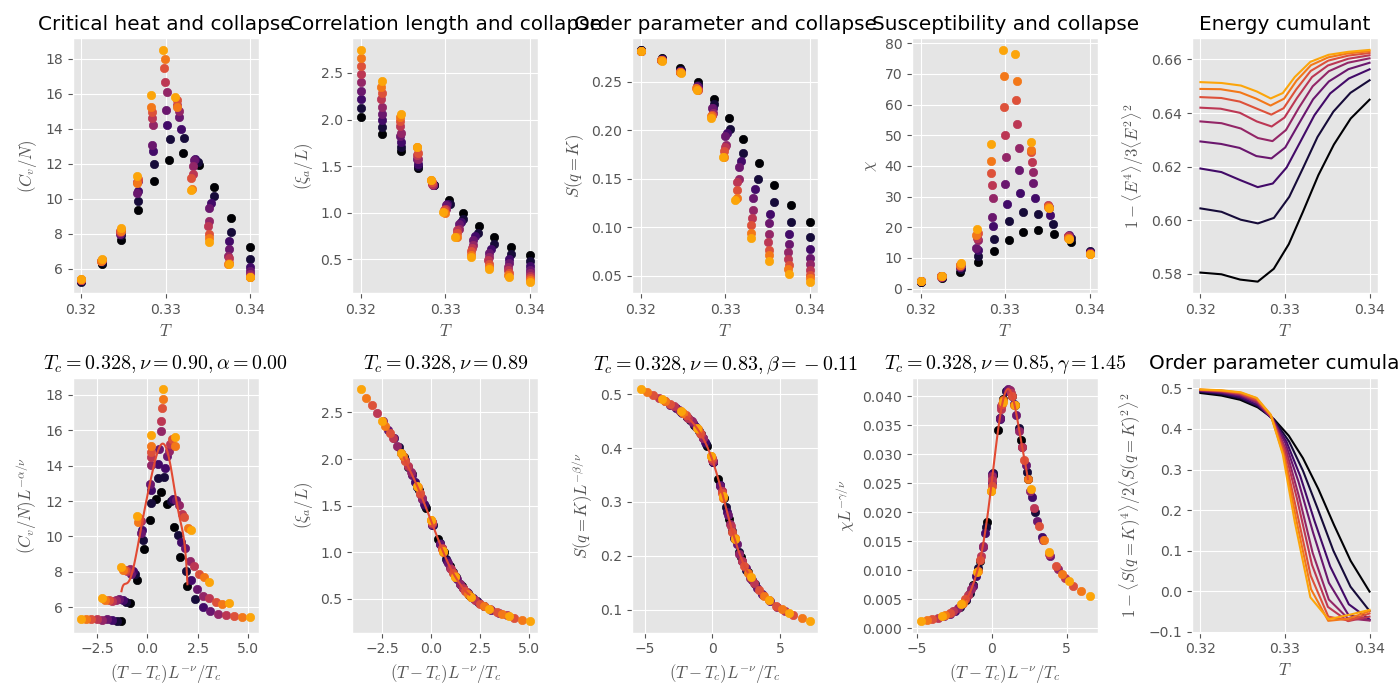

In [14]:
skip=50000
plot_all_collapse(
    [c for c in get_all_curves(["new-data/vsweeps/binder/0.7/*/energy.dat"])],
    [c for c in get_all_curves(["new-data/vsweeps/binder/0.7/*/order.dat"], prop="corr")],
    [c for c in get_all_curves(["new-data/vsweeps/binder/0.7/*/order.dat"], prop="k")],
    [c for c in get_all_curves(["new-data/vsweeps/binder/0.7/*/order.dat"], prop="ksus")],
    [c for c in get_all_curves(["new-data/vsweeps/binder/0.7/*/energy.dat"], prop="eb")],
    [c for c in get_all_curves(["new-data/vsweeps/binder/0.7/*/order.dat"], prop="kb")],
    (0.32, 0.33),
    (0.5, 0.9)
)

### J=0.8

[ 4.08200000e-01  1.20000000e+00  8.99655536e-02  3.91474922e-06
 -8.29174724e-08  3.93859733e-06  2.18000212e-07]
[ 4.08200000e-01  1.02851561e+00 -1.10752739e-01  2.42238139e-06
  1.00375212e-07  4.88754692e-06 -1.21015790e-07]
[ 4.08200000e-01  1.09195450e+00 -2.39363274e-01  8.83505642e-07
  5.56301034e-09  2.87023585e-07  8.39259065e-08]


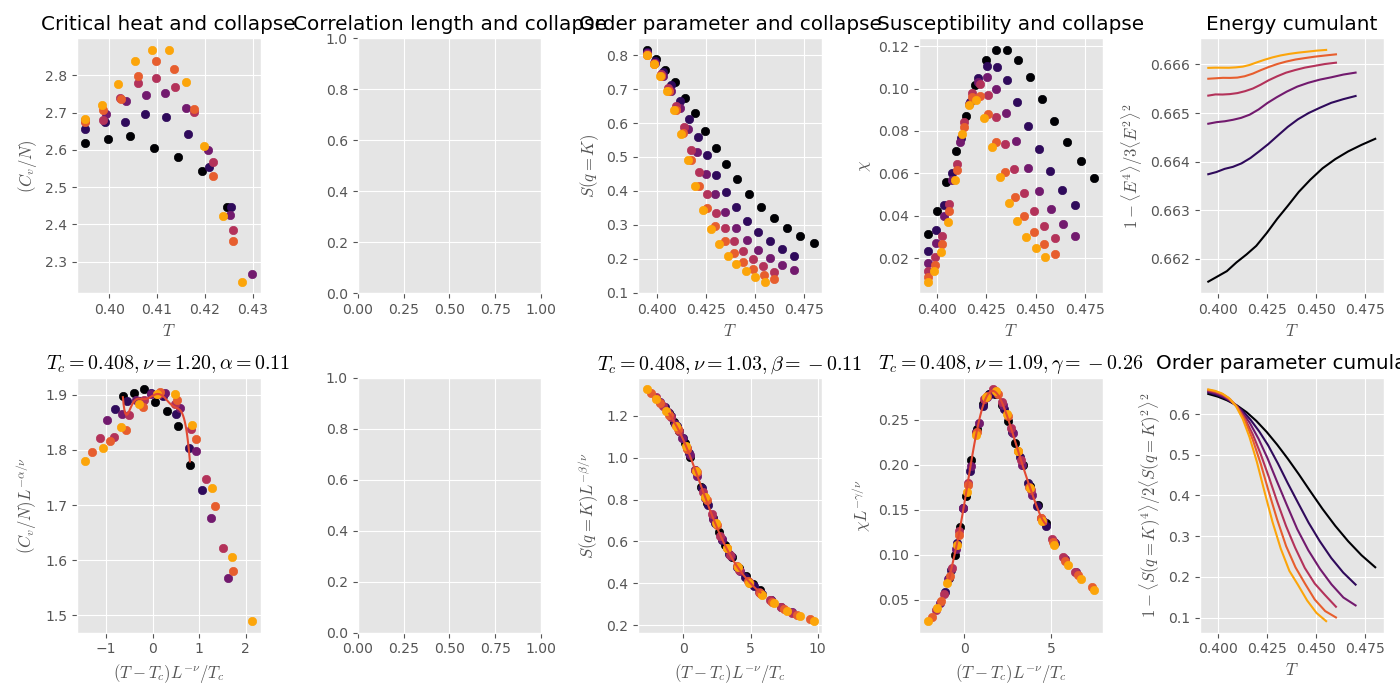

In [13]:
curves = curves_from_moments(get_all_moments("new-data/vsweeps/binder-slp/0.8/*/histogram.dat", "new-data/binder-slp-0.8.pkl"))

plot_all_collapse(
    pick_curve(curves, "cv", bounds=(0.3, 0.43)),
    None,
    pick_curve(curves, "s"),
    pick_curve(curves, "schi"),
    pick_curve(curves, "e4"),
    pick_curve(curves, "s4"),
    0.4082,
    (1, 1.2),
    alpha_range=(0, 0.5)
)

[ 4.36200000e-01  1.50000000e+00  1.11118661e-01  2.52451676e-04
 -2.38791879e-05]
[ 4.36200000e-01  1.03139001e+00 -1.17429382e-01  2.50780413e-05
  2.63933962e-06]
[ 4.36200000e-01  1.07988024e+00  1.77931884e+00  6.66849127e-05
 -3.54348577e-06]


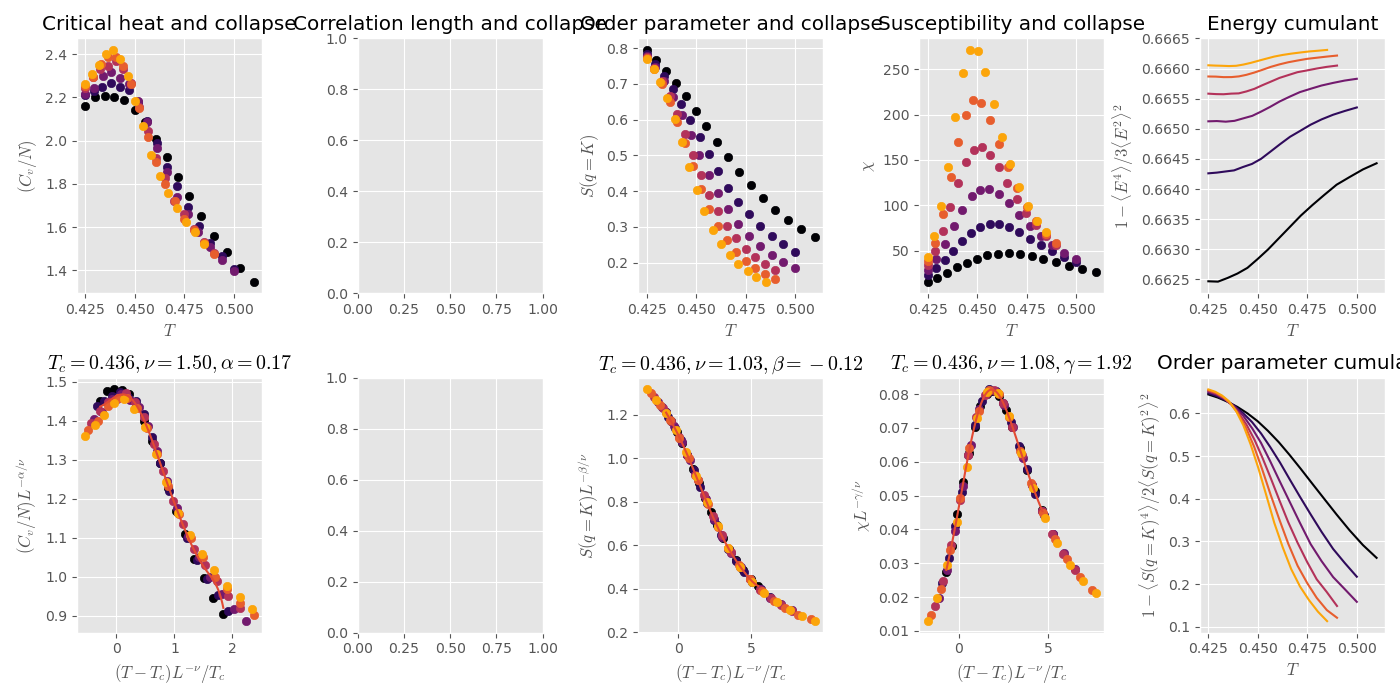

In [46]:
curves = curves_from_moments(get_all_moments("new-data/vsweeps/binder-slp/0.9/*/histogram.dat", "new-data/binder-slp-0.9.pkl"))

plot_all_collapse(
    pick_curve(curves, "cv"),
    None,
    pick_curve(curves, "s"),
    pick_curve(curves, "schi"),
    pick_curve(curves, "e4"),
    pick_curve(curves, "s4"),
    0.4362,
    (0.5, 1.5)
)

### J=1

[3.32409400e-01 8.80600000e-01 4.76105836e-01 3.40069975e-09
 2.57465252e-12]
[ 3.32433819e-01  8.80600000e-01  0.00000000e+00 -1.33777602e-12
  0.00000000e+00]
[ 3.32224561e-01  8.80600000e-01 -1.11360797e-01  2.36257022e-08
 -7.19361619e-13]
[3.32463243e-01 8.80600000e-01 1.70659033e+00 8.88735658e-08
 5.48471922e-13]


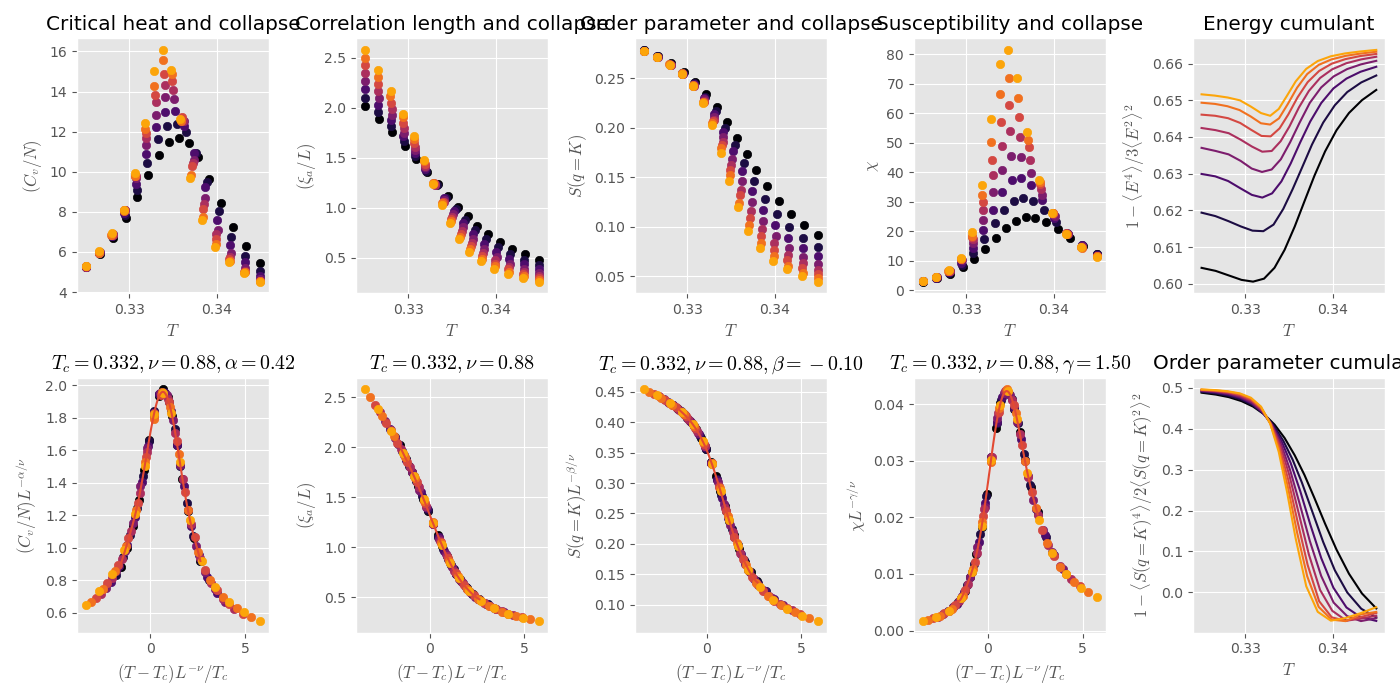

In [13]:
skip=50000
plot_all_collapse(
    [c for c in get_all_curves(["new-data/vsweeps/binder/1b/*/energy.dat"]) if c[0] > 36],
    [c for c in get_all_curves(["new-data/vsweeps/binder/1b/*/order.dat"], prop="corr") if c[0] > 36],
    [c for c in get_all_curves(["new-data/vsweeps/binder/1b/*/order.dat"], prop="k") if c[0] > 36],
    [c for c in get_all_curves(["new-data/vsweeps/binder/1b/*/order.dat"], prop="ksus") if c[0] > 36],
    [c for c in get_all_curves(["new-data/vsweeps/binder/1b/*/energy.dat"], prop="eb") if c[0] > 36],
    [c for c in get_all_curves(["new-data/vsweeps/binder/1b/*/order.dat"], prop="kb") if c[0] > 36],
    (0.33, 0.335),
    0.8806
)

In [18]:
curves = curves_from_moments(get_all_moments("new-data/vsweeps/binder-slp/1/*/histogram.dat", "new-data/binder-slp-1.pkl"))

plot_all_collapse(
    pick_curve(curves, "c"),
    None,
    pick_curve(curves, "s"),
    pick_curve(curves, "s_chi"),
    pick_curve(curves, "b_e"),
    pick_curve(curves, "b_s"),
    0.4617,
    (1, 1.2)
)

KeyError: 's_chi'

### 1.5

In [27]:
# curves = curves_from_moments(get_all_moments("new-data/vsweeps/binder-slp/1.5/*/histogram.dat", "new-data/binder-slp-1.5.pkl"))
curves = curves_from_moments(get_all_moments("new-data/vsweeps/binder-slp/1.5/*/histogram.dat", "new-data/binder-slp-1.5c.pkl"))

plot_all_collapse(
    pick_curve(curves, "cv", bounds=(0.5, 0.65)),
    None,
    pick_curve(curves, "s"),
    pick_curve(curves, "s_chi"),
    pick_curve(curves, "b_e"),
    pick_curve(curves, "b_s"),
    (0.5, 0.6),
    (0.9, 1.3),
    alpha_range=(0, 0.4)
)

KeyError: 's_chi'

[ 5.69000000e-01  1.44797306e+00  6.97976352e-02  8.85928843e-09
 -1.86390334e-08  1.51797809e-09 -2.81810101e-07]
[ 5.69000000e-01  1.05372136e+00 -1.18403906e-01  2.99518715e-06
 -9.86277270e-08 -3.00832082e-06  9.55990204e-08]
[ 5.69000000e-01  1.11257204e+00  1.80794406e+00  3.58012216e-06
 -7.42742025e-06  3.09355384e-06  1.43205159e-04]


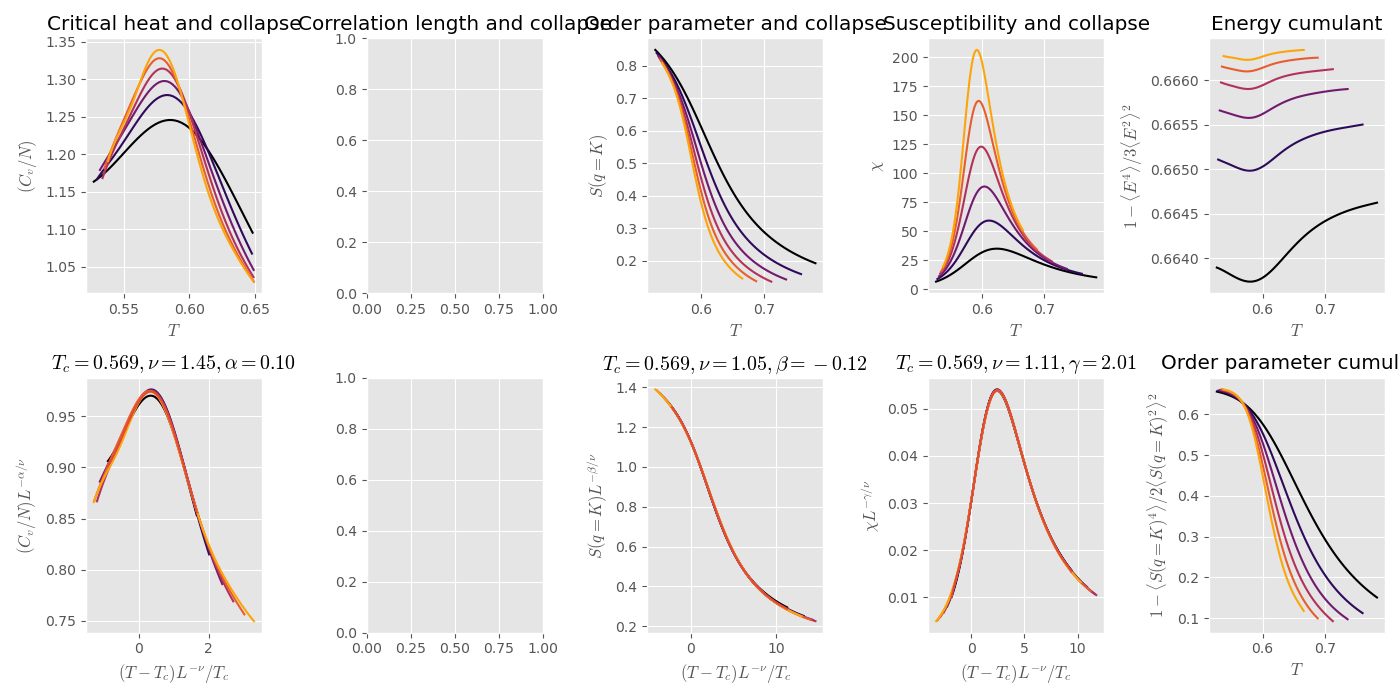

In [35]:
curves = curves_from_jsons("new-data/mhr/{}_slp_1.5.json", range(36, 96+1, 12))

plot_all_collapse(
    pick_curve(curves, "cv", bounds=(0.5, 0.65)),
    None,
    pick_curve(curves, "s"),
    pick_curve(curves, "chi_s"),
    pick_curve(curves, "b_e"),
    pick_curve(curves, "b_s"),
    0.569,
    (1, 2),
    alpha_range=(0, 0.4)
)

### 2

[ 3.33847162e-01  8.98808038e-01  4.84500903e-01 -1.48128247e-06
 -1.32608968e-08]
[ 3.33909632e-01  8.51591624e-01  0.00000000e+00 -1.48210089e-09
  1.78845959e-13]
[ 3.34316536e-01  8.00000000e-01 -1.53350049e-01 -1.84133844e-05
 -4.97823827e-08]
[3.34005204e-01 8.31870498e-01 1.73483674e+00 4.00319964e-05
 2.20885917e-07]


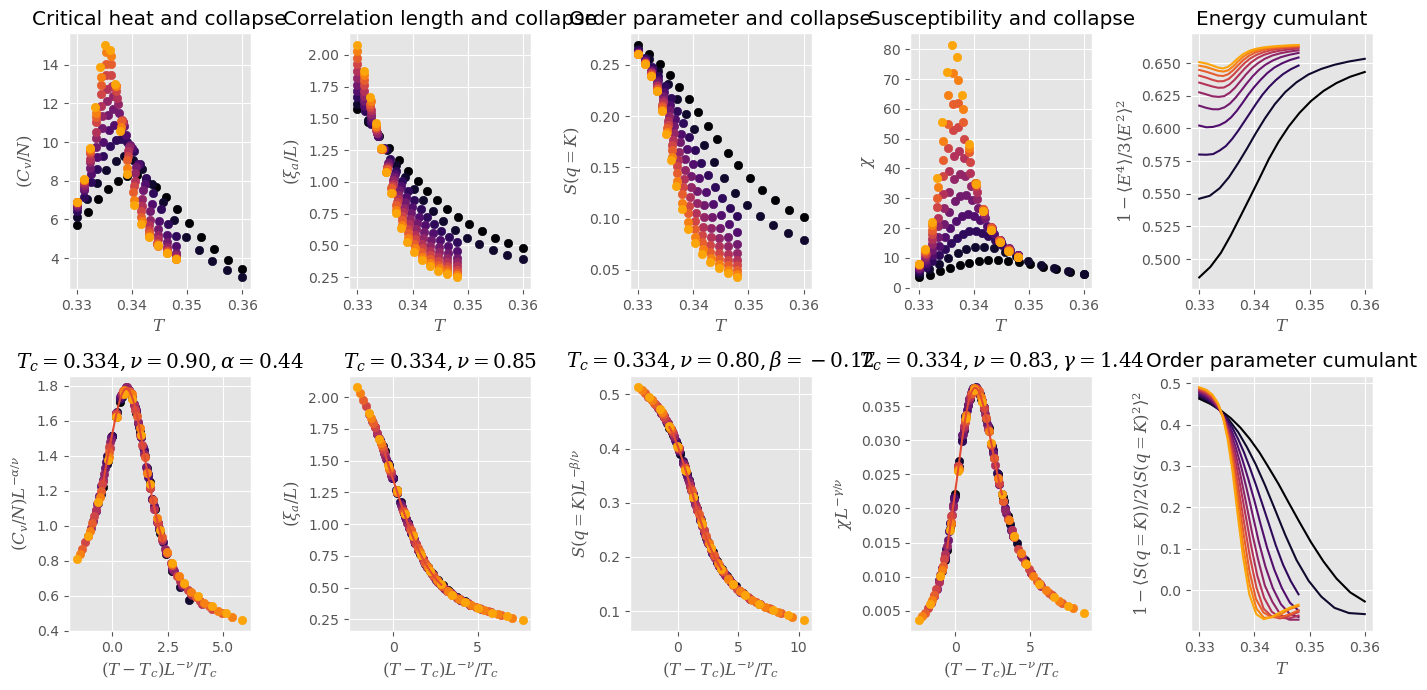

In [95]:
skip=50000
plot_all_collapse(
    [c for c in get_all_curves(["new-data/vsweeps/binder/2/*/energy.dat"]) if c[0] > 0],
    [c for c in get_all_curves(["new-data/vsweeps/binder/2/*/order.dat"], prop="corr") if c[0] > 0],
    [c for c in get_all_curves(["new-data/vsweeps/binder/2/*/order.dat"], prop="k") if c[0] > 0],
    [c for c in get_all_curves(["new-data/vsweeps/binder/2/*/order.dat"], prop="ksus") if c[0] > 0],
    [c for c in get_all_curves(["new-data/vsweeps/binder/2/*/energy.dat"], prop="eb") if c[0] > 0],
    [c for c in get_all_curves(["new-data/vsweeps/binder/2/*/order.dat"], prop="kb") if c[0] > 0],
    (0.333, 0.335),
    (0.8, 0.9)
)

[ 6.20001881e-01  1.50000000e+00  5.00000000e-01 -1.32101381e-05
 -2.61781673e-08  5.72687627e-06  2.81871017e-07]


[ 6.50534252e-01  1.04264200e+00 -1.39522579e-01  1.05584514e-07
  5.48804779e-08 -2.48041818e-08  6.78395603e-08]
[ 6.47424718e-01  1.12435812e+00 -1.77114239e-01  1.09361989e-07
  1.92273314e-08  7.47572299e-08 -9.95521111e-08]


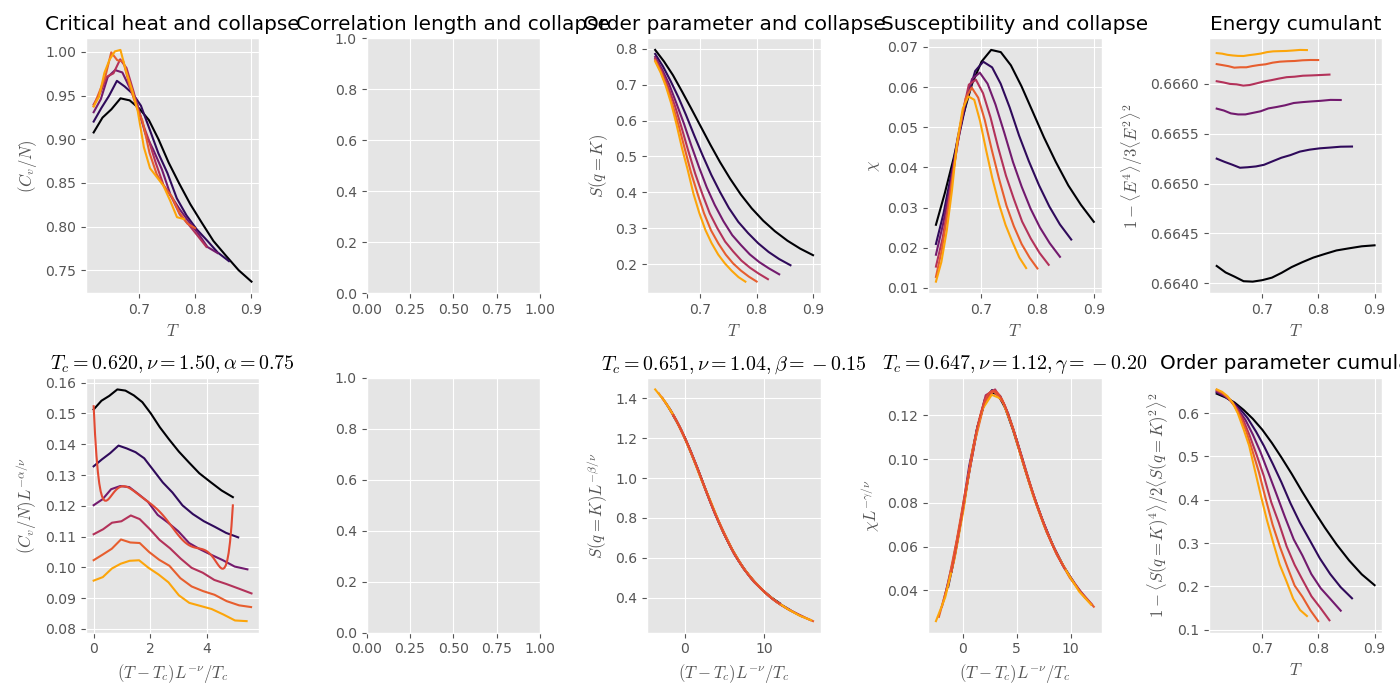

In [39]:
curves = curves_from_moments(get_all_moments("new-data/vsweeps/binder-slp/2/*/histogram.dat", "new-data/binder-slp-2.pkl"))

plot_all_collapse(
    pick_curve(curves, "cv"),
    None,
    pick_curve(curves, "s"),
    pick_curve(curves, "chi_s"),
    pick_curve(curves, "b_e"),
    pick_curve(curves, "b_s"),
    (0.6, 0.8),
    (0.5, 1.5)
)